# Chapter 4.2 - 한국어 텍스트 분류, P145 

## Initialize

In [59]:
# For M1 macs: https://cpuu.postype.com/post/9091007
#from tensorflow.python.framework.ops import disable_eager_execution
#disable_eager_execution()
#from tensorflow.python.compiler.mlcompute import mlcompute
#mlcompute.set_mlc_device(device_name='gpu')

%reset

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tqdm import tqdm
import re
import json
#from bs4 import BeautifulSoup
#from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.python.ops.math_ops import reduce_prod
from konlpy.tag import Okt
#from wordcloud import WordCloud
#from tensorflow.math import reduce_prod

%matplotlib inline

SEED_NUM = 1234
tf.random.set_seed(SEED_NUM)

DATA_PATH = "/Users/choijuhwan/Workspace/Git_Repos/korean-hate-speech-detection/study/nsmc-master/"

## Load data

In [60]:
df_train = pd.read_csv(DATA_PATH + "ratings_train.txt", header=0, delimiter="\t", quoting=3)
df_test = pd.read_csv(DATA_PATH + "ratings_test.txt", header=0, delimiter="\t", quoting=3)

dataframes = [df_train, df_test]

## Preprocessing

In [61]:
import re

regular_expression1 = "[^ㄱ-ㅎㅏ-ㅣ가-힣 ]"

for df in dataframes:
    df['document'] = df['document'].str.replace(regular_expression1, "")
    
    print(df.head)

<ipython-input-61-c1849740ca76>:6: FutureWarning: The default value of regex will change from True to False in a future version.
  df['document'] = df['document'].str.replace(regular_expression1, "")
<ipython-input-61-c1849740ca76>:6: FutureWarning: The default value of regex will change from True to False in a future version.
  df['document'] = df['document'].str.replace(regular_expression1, "")
<bound method NDFrame.head of               id                                           document  label
0        9976970                                  아 더빙 진짜 짜증나네요 목소리      0
1        3819312                         흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나      1
2       10265843                                  너무재밓었다그래서보는것을추천한다      0
3        9045019                          교도소 이야기구먼 솔직히 재미는 없다평점 조정      0
4        6483659  사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...      1
...          ...                                                ...    ...
149995   6222902                             

In [62]:
okt = Okt()

review_text = okt.morphs(df_train['document'][0], stem=True)
print(review_text)

stop_words = set(['은', '는', '이', '가', '하', '아', '것', '들', '의', '있', '되', '수', '보', '주', '등', '한'])
clean_text = [word for word in review_text if not word in stop_words]

print(clean_text)

['아', '더빙', '진짜', '짜증나다', '목소리']
['더빙', '진짜', '짜증나다', '목소리']


In [63]:
# Spell check
# Remove stopwords
# Make splited words to sentences

from hanspell import spell_checker

def preprocessing(text):
    okt = Okt()
    stop_words = set(['은', '는', '이', '가', '하', '아', '것', '들', '의', '있', '되', '수', '보', '주', '등', '한'])

    if type(text) != str:
        return " "

    #text = spell_checker.check(text).checked

    tmp = okt.morphs(text, stem=True)
    result = []
    for word in tmp:
        if word not in stop_words:
            result.append(word)

    #clean_text = ' '.join(result)

    return result

In [64]:
texts = []
for i in range(0, 5):
    text = preprocessing(df_train['document'][i])
    texts.append(text)

print(texts)

[['더빙', '진짜', '짜증나다', '목소리'], ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍다', '않다'], ['너', '무재', '밓었', '다그', '래서', '보다', '추천', '다'], ['교도소', '이야기', '구먼', '솔직하다', '재미', '없다', '평점', '조정'], ['사이', '몬페', '그', '익살스럽다', '연기', '돋보이다', '영화', '스파이더맨', '에서', '늙다', '보이다', '하다', '커스틴', '던스트', '너무나도', '이쁘다', '보이다']]


In [65]:
"""
for i in tqdm(range(0, df_train.shape[0])):
    df_train['document'][i] = preprocessing(df_train['document'][i])

for i in tqdm(range(0, df_test.shape[0])):
    df_test['document'][i] = preprocessing(df_test['document'][i])
"""

for df in dataframes:
    for i in tqdm(range(0, df.shape[0])):
        df['document'][i] = preprocessing(df['document'][i])

print(df_train.head())
print(df_test.head())

  0%|          | 0/150000 [00:00<?, ?it/s]<ipython-input-65-e43b9525dc34>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['document'][i] = preprocessing(df['document'][i])
100%|██████████| 50000/50000 [02:38<00:00, 316.42it/s]         id                                           document  label
0   9976970                                [더빙, 진짜, 짜증나다, 목소리]      0
1   3819312       [흠, 포스터, 보고, 초딩, 영화, 줄, 오버, 연기, 조차, 가볍다, 않다]      1
2  10265843                     [너, 무재, 밓었, 다그, 래서, 보다, 추천, 다]      0
3   9045019               [교도소, 이야기, 구먼, 솔직하다, 재미, 없다, 평점, 조정]      0
4   6483659  [사이, 몬페, 그, 익살스럽다, 연기, 돋보이다, 영화, 스파이더맨, 에서, 늙다...      1
        id                                           document  label
0  6270596                                            [굳다, ㅋ]      1
1  9274899              

In [68]:
# Integer index

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train['document'])
train_sequences = tokenizer.texts_to_sequences(df_train['document'])
test_sequences = tokenizer.texts_to_sequences(df_test['document'])

[648, 93]


In [100]:
def show_sequences(line_num, df='train'):
    array_num = line_num - 2
    if df == 'train':
        print(df_train['document'][array_num], train_sequences[array_num])
    else:
        print(df_test['document'][array_num], test_sequences[array_num])

#show_sequences(2063, 'test')
#show_sequences(2502, 'test')
#show_sequences(2, 'train')

show_sequences(49626, 'test')

['자넷', '잭슨', '촬영', '전', '투팍', '에게', '에이즈', '검사', '를', '요구', '하다', '정말', '역겹다', 'ㅉ'] [20912, 3393, 959, 170, 156, 8672, 2894, 7, 4226, 3, 14, 897, 2564]


In [120]:
# Make vocabulary

vocab = tokenizer.word_index
vocab["<PAD>"] = 0

datas = {}
datas['vocab'] = vocab
datas['vocab_size'] = len(vocab)

#print(datas['vocab'])
#print(datas['vocab_size'])

In [101]:
# Padding for train data & test data

MAX_SEQUENCE_LENGTH = 10

train_inputs = pad_sequences(train_sequences, maxlen = MAX_SEQUENCE_LENGTH, padding='post')
train_labels = np.array(df_train['label'])

test_inputs = pad_sequences(test_sequences, maxlen = MAX_SEQUENCE_LENGTH, padding='post')
test_labels = np.array(df_test['label'])
test_id = np.array(df_test['id'])

#print(train_inputs.shape)
#print(type(train_inputs))
#print(train_inputs)

#print(train_labels.shape)
#print(type(train_labels))
#print(train_labels)

## CNN Model

### Define hyperparameter

In [282]:
model_name = 'CNN_classifier_kr'
BATCH_SIZE = 150
NUM_EPOCHS = 5
VALID_SPLIT = 0.1
MAX_LEN = train_inputs.shape[1]

kargs = {'model_name': model_name,
        'vocab_size': datas['vocab_size'],
        'embedding_dimension': 100,
        'dropout_rate': 0.5,
        'num_filters': 50,
        'dense_dimension': 100,
        'output_dimension': 1}

### Model implementation

In [283]:
class CNNclassifier(tf.keras.Model):
    def __init__(self, **kargs):
        super(CNNclassifier, self).__init__(name=kargs['model_name'])

        self.embedding = tf.keras.layers.Embedding(input_dim=kargs['vocab_size'], output_dim=kargs['embedding_dimension'])
        self.dropout = tf.keras.layers.Dropout(kargs['dropout_rate'])

        self.conv1 = tf.keras.layers.Conv1D(filters=kargs['num_filters'], kernel_size=3, padding='valid', activation='relu')
        self.conv2 = tf.keras.layers.Conv1D(filters=kargs['num_filters'], kernel_size=3, padding='valid', activation='relu')
        self.conv3 = tf.keras.layers.Conv1D(filters=kargs['num_filters'], kernel_size=3, padding='valid', activation='relu')

        self.pooling = tf.keras.layers.MaxPool1D()

        self.fc1 = tf.keras.layers.Dense(units=kargs['dense_dimension'], activation=tf.keras.activations.relu)
        self.fc2 = tf.keras.layers.Dense(units=kargs['dense_dimension'], activation=tf.keras.activations.relu)
        self.fc_last = tf.keras.layers.Dense(units=1, activation=tf.keras.activations.sigmoid)

    def call(self, x):
        x = self.embedding(x)
        x = self.dropout(x)

        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.pooling(x)
        
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.dropout(x)

        x = self.fc_last(x)

        return x

### Generate model instance

In [284]:
model = CNNclassifier(**kargs)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
            loss=tf.keras.losses.BinaryCrossentropy(),
            metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')])

### Model learning

> Memo 
>
> numpy 1.20 이상은 뭔가 [에러](https://stackoverflow.com/questions/58479556/notimplementederror-cannot-convert-a-symbolic-tensor-2nd-target0-to-a-numpy)가 있음
>
> 난 pip로 Build 안돼서 conda로 1.19.5 설치했음
>
> numpy array 말고 Tensor가 들어가야하는듯 -> 꼭 그건 아니고 버전만 맞추면 됨

In [285]:
#from tensorflow.python.ops.math_ops import reduce_prod
from tensorflow.math import reduce_prod

earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=2)

checkpoint_path = DATA_PATH + model_name + '/weights.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)

if os.path.exists(checkpoint_dir):
    pass
else:
    os.makedirs(checkpoint_dir, exist_ok=True)

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

#train_inputs = tf.convert_to_tensor(train_inputs)
#train_labels = tf.convert_to_tensor(train_labels)

history = model.fit(train_inputs, train_labels, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_split=VALID_SPLIT, callbacks=[earlystop_callback, cp_callback])

model.summary()

Epoch 1/5
900/900 [==============================] - 14s 15ms/step - loss: 0.6621 - accuracy: 0.5647 - val_loss: 0.4811 - val_accuracy: 0.7616

Epoch 00001: val_accuracy improved from -inf to 0.76160, saving model to /Users/choijuhwan/Workspace/Git_Repos/korean-hate-speech-detection/study/nsmc-master/CNN_classifier_kr/weights.h5
Epoch 2/5
900/900 [==============================] - 14s 16ms/step - loss: 0.4907 - accuracy: 0.7595 - val_loss: 0.4482 - val_accuracy: 0.7840

Epoch 00002: val_accuracy improved from 0.76160 to 0.78397, saving model to /Users/choijuhwan/Workspace/Git_Repos/korean-hate-speech-detection/study/nsmc-master/CNN_classifier_kr/weights.h5
Epoch 3/5
900/900 [==============================] - 14s 16ms/step - loss: 0.4552 - accuracy: 0.7822 - val_loss: 0.4380 - val_accuracy: 0.7879

Epoch 00003: val_accuracy improved from 0.78397 to 0.78787, saving model to /Users/choijuhwan/Workspace/Git_Repos/korean-hate-speech-detection/study/nsmc-master/CNN_classifier_kr/weights.h5
E

## RNN Model

### Define hyperparameter

In [264]:
model_name = 'RNN_classifier_kr'
BATCH_SIZE = 150
NUM_EPOCHS = 5
VALID_SPLIT = 0.1
MAX_LEN = train_inputs.shape[1]

kargs = {'model_name': model_name,
        'vocab_size': datas['vocab_size'],
        'embedding_dimension': 100,
        'dropout_rate': 0.2,
        'lstm_dimension': 150,
        'dense_dimension': 150,
        'output_dimension': 1}

### Define model

In [265]:
class RNNclassifier(tf.keras.Model):
    def __init__(self, **kargs):
        super(RNNclassifier, self).__init__(name=kargs['model_name'])

        self.embedding = tf.keras.layers.Embedding(input_dim=kargs['vocab_size'], output_dim=kargs['embedding_dimension'])
        self.lstm1 = tf.keras.layers.LSTM(kargs['lstm_dimension'], return_sequences=True)
        self.lstm2 = tf.keras.layers.LSTM(kargs['lstm_dimension'])
        self.dropout = tf.keras.layers.Dropout(kargs['dropout_rate'])
        self.fc1 = tf.keras.layers.Dense(units=kargs['dense_dimension'], activation=tf.keras.activations.relu)
        self.fc2 = tf.keras.layers.Dense(units=1, activation=tf.keras.activations.sigmoid)

    def call(self, x):
        x = self.embedding(x)
        x = self.dropout(x)

        x = self.lstm1(x)
        x = self.lstm2(x)
        x = self.dropout(x)

        x = self.fc1(x)
        x = self.dropout(x)

        x = self.fc2(x)

        return x

### Generate model instance

In [266]:
model = RNNclassifier(**kargs)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
            loss=tf.keras.losses.BinaryCrossentropy(),
            metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')])

### Model learning

In [267]:
#from tensorflow.python.ops.math_ops import reduce_prod
from tensorflow.math import reduce_prod

earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=2)

checkpoint_path = DATA_PATH + model_name + '/weights.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)

if os.path.exists(checkpoint_dir):
    pass
else:
    os.makedirs(checkpoint_dir, exist_ok=True)

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

#train_inputs = tf.convert_to_tensor(train_inputs)
#train_labels = tf.convert_to_tensor(train_labels)

history = model.fit(train_inputs, train_labels, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_split=VALID_SPLIT, callbacks=[earlystop_callback, cp_callback])

Epoch 1/5
900/900 [==============================] - 34s 37ms/step - loss: 0.5734 - accuracy: 0.6807 - val_loss: 0.4052 - val_accuracy: 0.8104

Epoch 00001: val_accuracy improved from -inf to 0.81040, saving model to /Users/choijuhwan/Workspace/Git_Repos/korean-hate-speech-detection/study/nsmc-master/RNN_classifier_kr/weights.h5
Epoch 2/5
900/900 [==============================] - 32s 35ms/step - loss: 0.3919 - accuracy: 0.8240 - val_loss: 0.3852 - val_accuracy: 0.8267

Epoch 00002: val_accuracy improved from 0.81040 to 0.82667, saving model to /Users/choijuhwan/Workspace/Git_Repos/korean-hate-speech-detection/study/nsmc-master/RNN_classifier_kr/weights.h5
Epoch 3/5
900/900 [==============================] - 32s 35ms/step - loss: 0.3589 - accuracy: 0.8429 - val_loss: 0.3827 - val_accuracy: 0.8323

Epoch 00003: val_accuracy improved from 0.82667 to 0.83233, saving model to /Users/choijuhwan/Workspace/Git_Repos/korean-hate-speech-detection/study/nsmc-master/RNN_classifier_kr/weights.h5
E

## Result

### Show model results

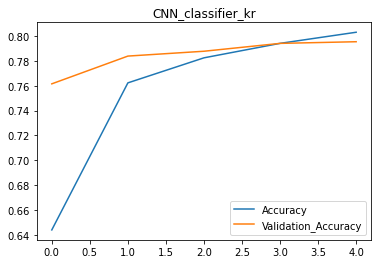

In [286]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label = "Accuracy")
plt.plot(history.history['val_accuracy'], label="Validation_Accuracy")

plt.title(kargs['model_name'])
plt.legend()
plt.show()

### Prediction & Evaluate

> Memo
>
> [AttributeError: 'str' object has no attribute 'decode'](https://stackoverflow.com/questions/53740577/does-any-one-got-attributeerror-str-object-has-no-attribute-decode-whi)
>
> h5py package를 2.10.0 버전으로 

In [287]:
SAVE_FILE_NAME = 'weight.h5'
DATA_OUT_PATH = DATA_PATH + "data_out/"

model.load_weights(os.path.join(checkpoint_path))

In [288]:
evaluations = model.evaluate(test_inputs, test_labels)

1563/1563 [==============================] - 3s 2ms/step - loss: 3.4547 - accuracy: 0.4997
